In [3]:
import os
import numpy as np
from PIL import Image
import glob
import random
from keras.utils import Sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Concatenate, ReLU
from tensorflow.keras.models import Model
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from PIL import Image
import tensorflow as tf
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
import tensorflow as tf

if tf.test.gpu_device_name():
    print("GPU is available")
else:
    print("GPU is NOT available")


GPU is NOT available


In [5]:
random.seed(1143)

def preparing_training_data_1(hazefree_images_dir, hazeeffected_images_dir):


    train_data = []
    validation_data = []

    hazy_data = glob.glob(hazeeffected_images_dir + "*.jpg")

    data_holder = {}

    for h_image in hazy_data:
        h_image = h_image.split("\\")[-1]
        id_ = h_image.split("_")[0] + "_" + h_image.split("_")[1] + ".jpg"
        if id_ in data_holder.keys():
            data_holder[id_].append(h_image)
        else:
            data_holder[id_] = []
            data_holder[id_].append(h_image)


    train_ids = []
    val_ids = []

    num_of_ids = len(data_holder.keys())
    print(num_of_ids)
    for i in range(num_of_ids):
        if i < num_of_ids*9/10:
            train_ids.append(list(data_holder.keys())[i])
        else:
            val_ids.append(list(data_holder.keys())[i])


    for id_ in list(data_holder.keys()):

        if id_ in train_ids:

            for hazy_image in data_holder[id_]:
                train_data.append([hazefree_images_dir + id_, hazeeffected_images_dir + hazy_image])


        else:
            for hazy_image in data_holder[id_]:
                validation_data.append([hazefree_images_dir + id_, hazeeffected_images_dir + hazy_image])



    random.shuffle(train_data)
    random.shuffle(validation_data)

    return train_data, validation_data

In [6]:
class HazyDataGenerator1(Sequence):
    def __init__(self, hazefree_images_dir, hazeeffected_images_dir, mode='train', batch_size=8):
        self.train_data, self.validation_data = preparing_training_data_1(hazefree_images_dir, hazeeffected_images_dir)
        self.mode = mode
        self.batch_size = batch_size
        if self.mode == 'train':
            self.data = self.train_data
            print("Number of Training Images:", len(self.train_data))
        else:
            self.data = self.validation_data
            print("Number of Validation Images:", len(self.validation_data))

        # Use the ImageDataGenerator for data augmentation
        self.data_generator = ImageDataGenerator(
            rescale=1.0 / 255.0,  # Normalize the pixel values to the range [0, 1]
            # Add more data augmentation options if needed (e.g., rotation, width/height shift, etc.)
        )

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, idx):
        batch_data = self.data[idx * self.batch_size: (idx + 1) * self.batch_size]
        batch_hazefree_images = []
        batch_hazy_images = []

        for hazefree_image_path, hazy_image_path in batch_data:
            hazefree_image = Image.open(hazefree_image_path)
            hazy_image = Image.open(hazy_image_path)

            # Resize the images to the desired size (480, 640) and convert to numpy arrays
            hazefree_image = np.array(hazefree_image.resize((640, 480), Image.LANCZOS))
            hazy_image = np.array(hazy_image.resize((640, 480), Image.LANCZOS))

            # Perform data augmentation (apply the same transformation to both hazy and hazefree images)
            #seed = np.random.randint(1, 1000)  # Generate a random seed for augmentation consistency
            #hazefree_image = self.data_generator.random_transform(hazefree_image, seed=seed)
            #hazy_image = self.data_generator.random_transform(hazy_image, seed=seed)

            # Normalize the pixel values to the range [0, 1]
            hazefree_image = hazefree_image / 255.0
            hazy_image = hazy_image / 255.0

            batch_hazefree_images.append(hazefree_image)
            batch_hazy_images.append(hazy_image)

        return np.array(batch_hazefree_images), np.array(batch_hazy_images)

In [7]:
# Set the paths to the hazy and haze-free image directories
train_hazy_images_dir = "E:\Keras\Dataset\Hazy_data\Hazy_affected\\"
train_original_images_dir = "E:\Keras\Dataset\Hazy_data\Hazy_free\\"

In [8]:
# Create custom data generators
train_data_generator = HazyDataGenerator1(
    hazefree_images_dir=train_original_images_dir,
    hazeeffected_images_dir=train_hazy_images_dir,
    mode='train', batch_size=8
)

1449
Number of Training Images: 24443


In [9]:
# Create custom data generators
val_data  = HazyDataGenerator1(
    hazefree_images_dir=train_original_images_dir,
    hazeeffected_images_dir=train_hazy_images_dir, mode = 'val', batch_size=8
)

1449
Number of Validation Images: 2813


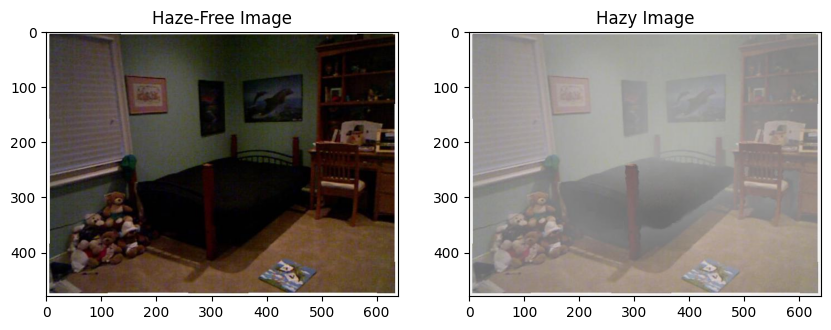

In [10]:
import matplotlib.pyplot as plt

# Function to convert numpy array back to an image
def array_to_image(array):
    return Image.fromarray((array * 255).astype(np.uint8))

# Fetch a batch of data from the train_data_generator
batch_hazefree_images, batch_hazy_images = train_data_generator[10]

# Print the first image from the batch
hazefree_image = array_to_image(batch_hazefree_images[0])
hazy_image = array_to_image(batch_hazy_images[0])

# Display the images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(hazefree_image)
plt.title("Haze-Free Image")

plt.subplot(1, 2, 2)
plt.imshow(hazy_image)
plt.title("Hazy Image")

plt.show()


In [11]:
# Get the batch of data using the train_data_generator
batch_data = train_data_generator.__getitem__(0)  # Get the first batch

# Extract the hazefree and hazy images from the batch
batch_hazefree_images, batch_hazy_images = batch_data

# Get the shape of the images
print("Shape of Hazefree Images:", batch_hazefree_images.shape)
print("Shape of Hazy Images:", batch_hazy_images.shape)

Shape of Hazefree Images: (8, 480, 640, 3)
Shape of Hazy Images: (8, 480, 640, 3)


# LD_Net Model

In [12]:
class LightDehazeNet(Model):

    def __init__(self):
        super(LightDehazeNet, self).__init__()

        # LightDehazeNet Architecture
        self.relu = ReLU()

        self.e_conv_layer1 = Conv2D(8, kernel_size=(1, 1), strides=(1, 1), padding='valid', use_bias=True)
        self.e_conv_layer2 = Conv2D(8, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True)
        self.e_conv_layer3 = Conv2D(8, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=True)
        self.e_conv_layer4 = Conv2D(16, kernel_size=(7, 7), strides=(1, 1), padding='same', use_bias=True)
        self.e_conv_layer5 = Conv2D(16, kernel_size=(3, 3),strides=(1, 1), padding='same', use_bias=True)
        self.e_conv_layer6 = Conv2D(16, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True)
        self.e_conv_layer7 = Conv2D(32, kernel_size=(3, 3),strides=(1, 1), padding='same', use_bias=True)
        self.e_conv_layer8 = Conv2D(3, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True)

    def call(self, img):
        pipeline = []
        pipeline.append(img)

        conv_layer1 = self.relu(self.e_conv_layer1(img))
        conv_layer2 = self.relu(self.e_conv_layer2(conv_layer1))
        conv_layer3 = self.relu(self.e_conv_layer3(conv_layer2))

        # concatenating conv1 and conv3
        concat_layer1 = Concatenate()([conv_layer1, conv_layer3])

        conv_layer4 = self.relu(self.e_conv_layer4(concat_layer1))
        conv_layer5 = self.relu(self.e_conv_layer5(conv_layer4))
        conv_layer6 = self.relu(self.e_conv_layer6(conv_layer5))

        # concatenating conv4 and conv6
        concat_layer2 = Concatenate()([conv_layer4, conv_layer6])

        conv_layer7 = self.relu(self.e_conv_layer7(concat_layer2))

        # concatenating conv2, conv5, and conv7
        concat_layer3 = Concatenate()([conv_layer2, conv_layer5, conv_layer7])

        conv_layer8 = self.relu(self.e_conv_layer8(concat_layer3))

        dehaze_image = self.relu((conv_layer8 * img) - conv_layer8 + 1)
        # J(x) = clean_image, k(x) = x8, I(x) = x, b = 1

        return dehaze_image

In [13]:
# Create an object of the model
ld_net1 = LightDehazeNet()

# Define the mean squared error (MSE) loss function
criterion = mean_squared_error

# Create the Adam optimizer
optimizer = Adam(learning_rate=0.001)

# Compile the model with the chosen optimizer and loss function
ld_net1.compile(optimizer=optimizer, loss=criterion)

In [ ]:
# Train the model
history = ld_net1.fit(
    train_data_generator,
    epochs=3,
    steps_per_epoch=round(len(train_data_generator)/8),
    validation_data=val_data,
    validation_steps=round(len(val_data)/8),
    batch_size=8
)

Epoch 1/3
294/382 [======================>.......] - ETA: 23:23 - loss: 0.0199

## Output Single Image and Save

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from PIL import Image
import tensorflow as tf
import os

def image_haze_removal(input_image, ld_net, save_folder):

    # Preprocess the input image
    hazy_image = img_to_array(input_image) / 255.0
    hazy_image = np.expand_dims(hazy_image, axis=0)

    # Perform haze removal using the Keras model
    dehaze_image = ld_net.predict(hazy_image)

    # Postprocess the output image
    dehaze_image = np.squeeze(dehaze_image, axis=0)
    dehaze_image = np.clip(dehaze_image, 0, 1)  # Clip values to [0, 1] range

    # Convert the output back to PIL Image format
    dehaze_image_pil = array_to_img(dehaze_image * 255.0)

    # Print and save the dehazed image
    print("Dehazed image:")
    display(dehaze_image_pil)

    # Save the dehazed image in the specified folder
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)

    # Assuming you have a unique filename for each dehazed image, for example, 'dehazed_1.jpg', 'dehazed_2.jpg', etc.
    # You can modify this part based on your naming convention and desired save format (JPEG, PNG, etc.).
    filename = os.path.join(save_folder, 'dehazed_image.jpg')
    dehaze_image_pil.save(filename)

    return dehaze_image_pil


In [ ]:
# Assuming you have an input PIL Image named 'input_image' and a save folder named 'output_folder'
dehazed_image = image_haze_removal(input_image, ld_net, save_folder='output_folder')

In [ ]:
from PIL import Image

def take_input_image():
    # Get the file path of the input image from the user
    input_path = input("Enter the path of the input image: ")

    try:
        # Open the image using PIL
        input_image = Image.open(input_path)
        return input_image
    except Exception as e:
        print("Error loading the image:", e)
        return None

# Take the input image from the user
input_image = take_input_image()

if input_image:
    # Now you can use the 'input_image' in the 'image_haze_removal' function
    # Assuming you have already defined and trained the Keras ld_net model
    ld_net = ...

    # Assuming you have an output folder named 'output_folder'
    dehazed_image = image_haze_removal(input_image, ld_net, save_folder='output_folder')


In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Load the image from a file
input_image_path = '/content/drive/MyDrive/LD-Net_Data/Input_Images/NYU2_24_7_3.jpg'

# Replace with the actual image path
input_image = load_img(input_image_path, target_size=(640, 480))
input_image

In [ ]:
# Assuming you have an input PIL Image named 'input_image' and a save folder named 'output_folder'
dehazed_image = image_haze_removal(input_image, ld_net, save_folder='/content/drive/MyDrive/LD-Net_Data/Input_Images')

### Display Dehazed Image

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have a single hazy input image
hazy_image_path = "path/to/your/hazy_image.jpg"

# Load the hazy image and preprocess it
hazy_image = Image.open(hazy_image_path)
hazy_image = hazy_image.resize((640, 480), Image.LANCZOS)  # Resize to the desired input size of the model
hazy_image = np.array(hazy_image) / 255.0  # Normalize pixel values to [0, 1]

# Reshape the input image to match the model's input shape (batch size = 1)
hazy_image = np.expand_dims(hazy_image, axis=0)

# Use the trained model to dehaze the image
predicted_dehazed_image = ld_net1.predict(hazy_image)

# Convert the predicted dehazed image from [0, 1] range to [0, 255] range for visualization
predicted_dehazed_image *= 255.0
predicted_dehazed_image = predicted_dehazed_image.squeeze().astype(np.uint8)

# Convert the numpy array back to an image
predicted_dehazed_image = Image.fromarray(predicted_dehazed_image)

# Display the input hazy image and the output dehazed image side by side
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(hazy_image[0])
plt.title("Input Hazy Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(predicted_dehazed_image)
plt.title("Output Dehazed Image")
plt.axis('off')

plt.show()